In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from skorch import NeuralNetRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
import joblib

sns.set(style='whitegrid')

In [170]:
# Load the dataset
df = pd.read_csv('final1.csv')
print("First few rows of the dataset:")
df.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,6.9,11.6,4.1
1,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.0,13.0,17.5
2,Amann-Hildenbrand et al. 2013,Opalinus Clay,25.0,2.5,13.0,14.0
3,Boulin et al. 2013,Ketzin Claystone,7.0,31.8,15.0,10.4
4,Boulin et al. 2013,Ketzin Claystone,25.0,15.6,15.0,13.0


In [171]:
df.shape

(63, 6)

In [172]:
# Load the dataset
df1 = pd.read_csv('final2.csv')
print("First few rows of the dataset:")
df1.head()

First few rows of the dataset:


,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


# Prediction of Breakthrough Pressure with 2 Variables: Direct Tests

## Exploratory Data Analysis

In [173]:
# Display the summary statistics
print("\nSummary statistics:")
df.describe()


Summary statistics:


,P’[MPa],Permeability [nD],Porosity [%],Breakthrough pressure [MPa]
count,59.000000,63.000000,63.000000,63.000000
mean,13.674576,1453.361905,16.095238,5.004603
std,7.136975,5981.324892,12.471457,4.935137
min,3.000000,0.600000,0.100000,0.030000
25%,8.250000,6.950000,5.700000,1.000000
50%,10.000000,29.300000,14.500000,4.100000
75%,20.000000,305.000000,23.600000,5.900000
max,28.000000,44000.000000,54.500000,27.800000


In [174]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
Reference                      0
Rock                           0
P’[MPa]                        4
Permeability [nD]              0
Porosity [%]                   0
Breakthrough pressure [MPa]    0
dtype: int64


In [175]:
# Check the data types of each column
print("\nData types of each column:")
print(df.dtypes)


Data types of each column:
Reference                       object
Rock                            object
P’[MPa]                        float64
Permeability [nD]              float64
Porosity [%]                   float64
Breakthrough pressure [MPa]    float64
dtype: object


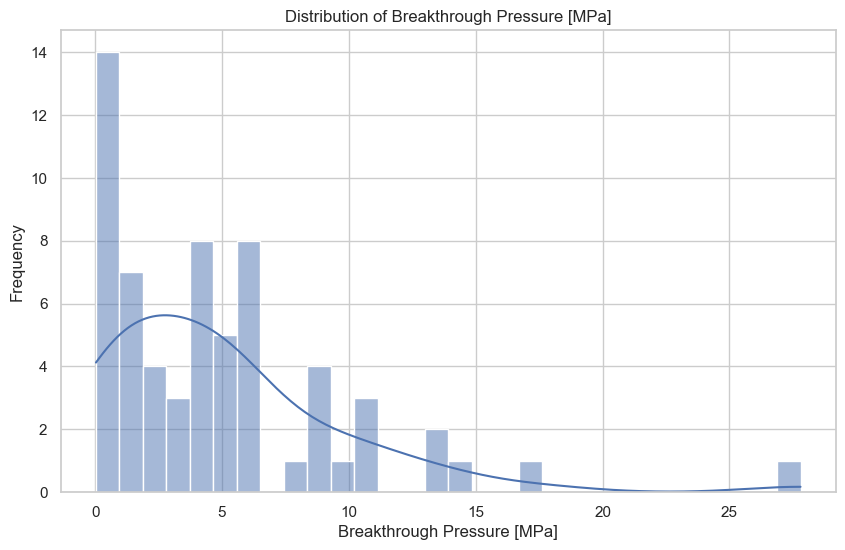

In [176]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Breakthrough pressure [MPa]'], bins=30, kde=True)
plt.title('Distribution of Breakthrough Pressure [MPa]')
plt.xlabel('Breakthrough Pressure [MPa]')
plt.ylabel('Frequency')
plt.show()

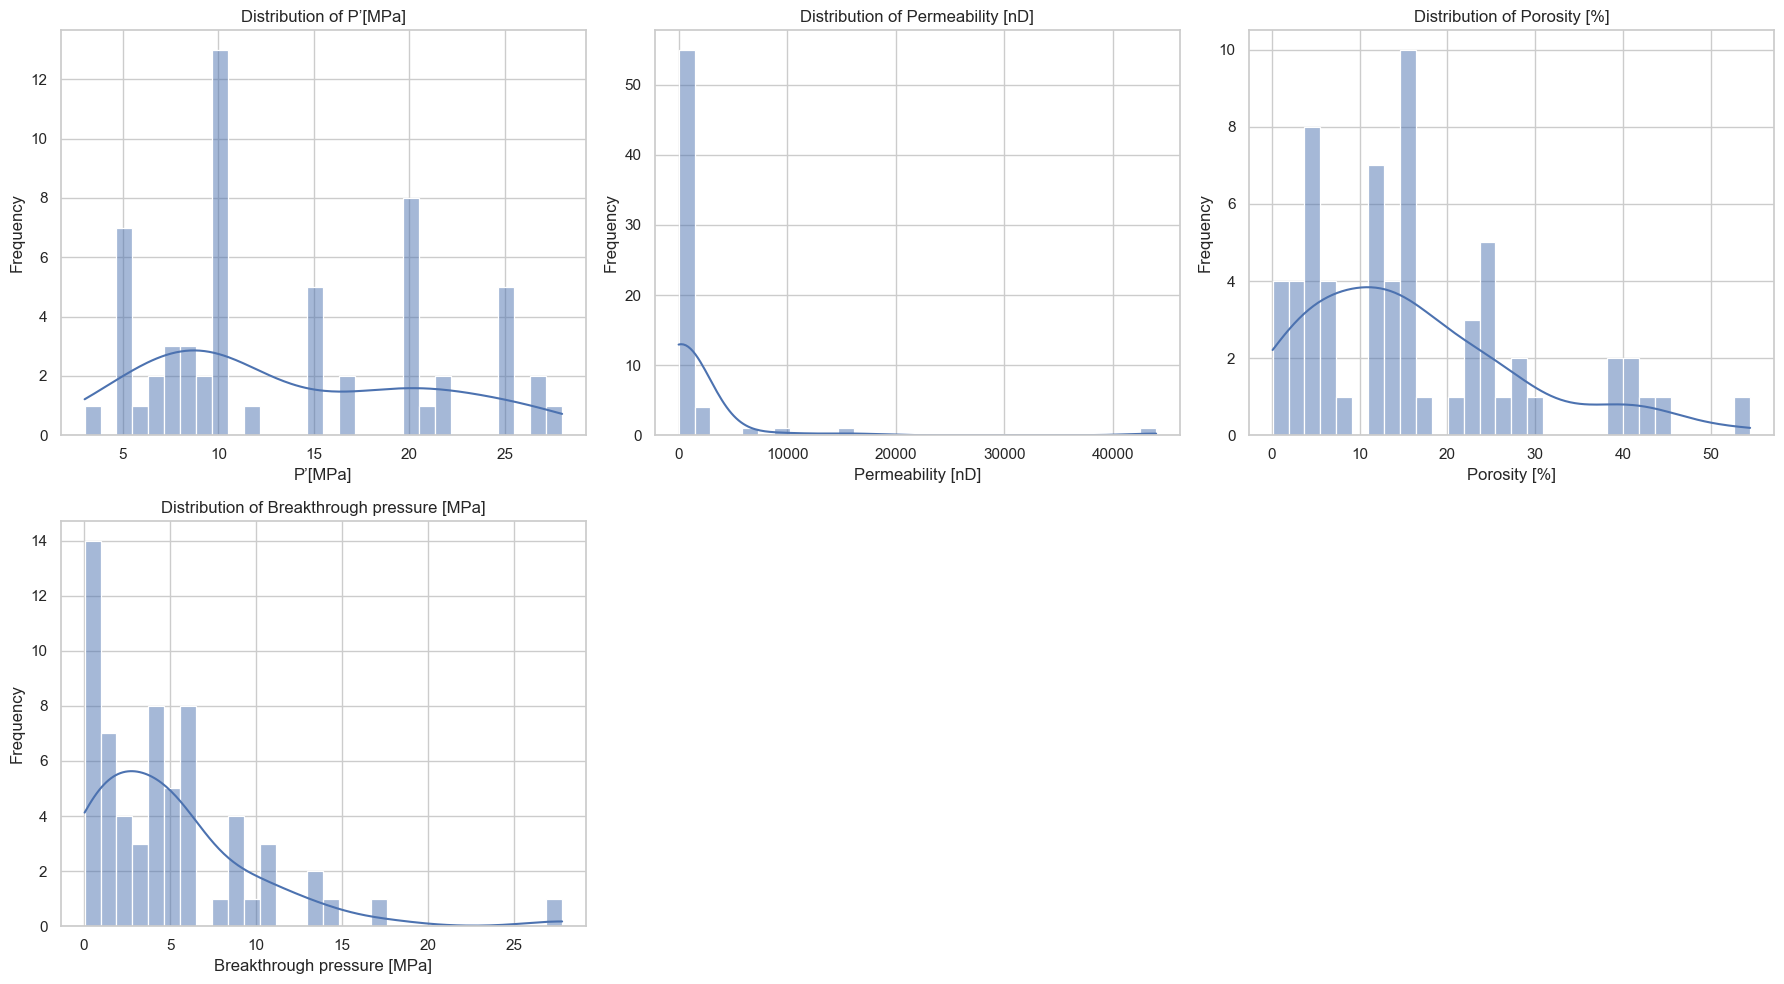

In [177]:
feature_columns = [ 'P’[MPa]',
       'Permeability [nD]', 'Porosity [%]', 'Breakthrough pressure [MPa]']

num_features = len(feature_columns)
num_rows = (num_features + 2) // 3  
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(feature_columns):
    sns.histplot(df[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

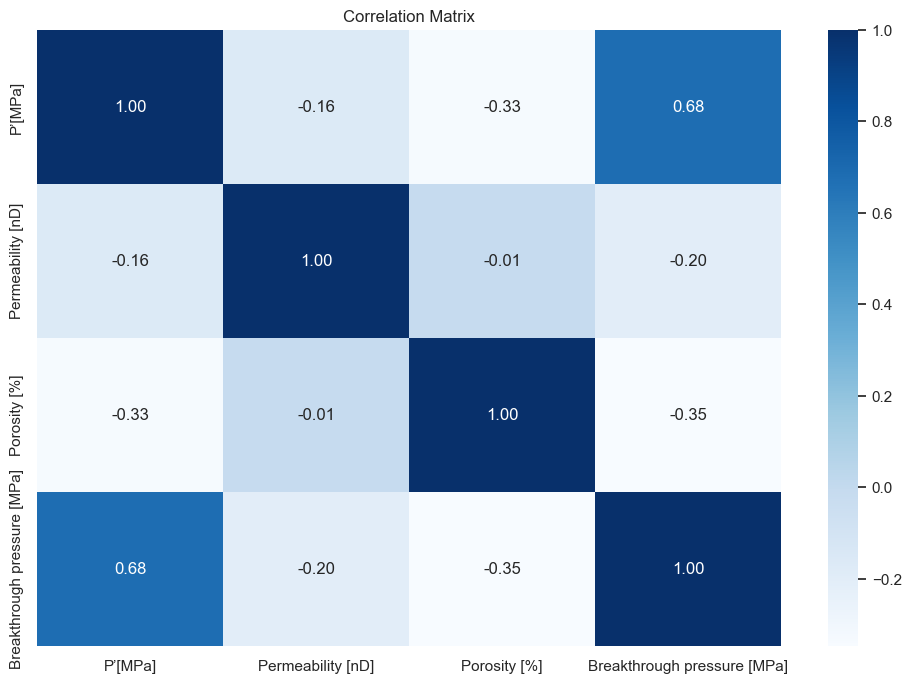

In [178]:
# Visualize correlations between features and the target variable
cols = ['P’[MPa]', 'Permeability [nD]', 'Porosity [%]', 'Breakthrough pressure [MPa]']
correlation_matrix = df[cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

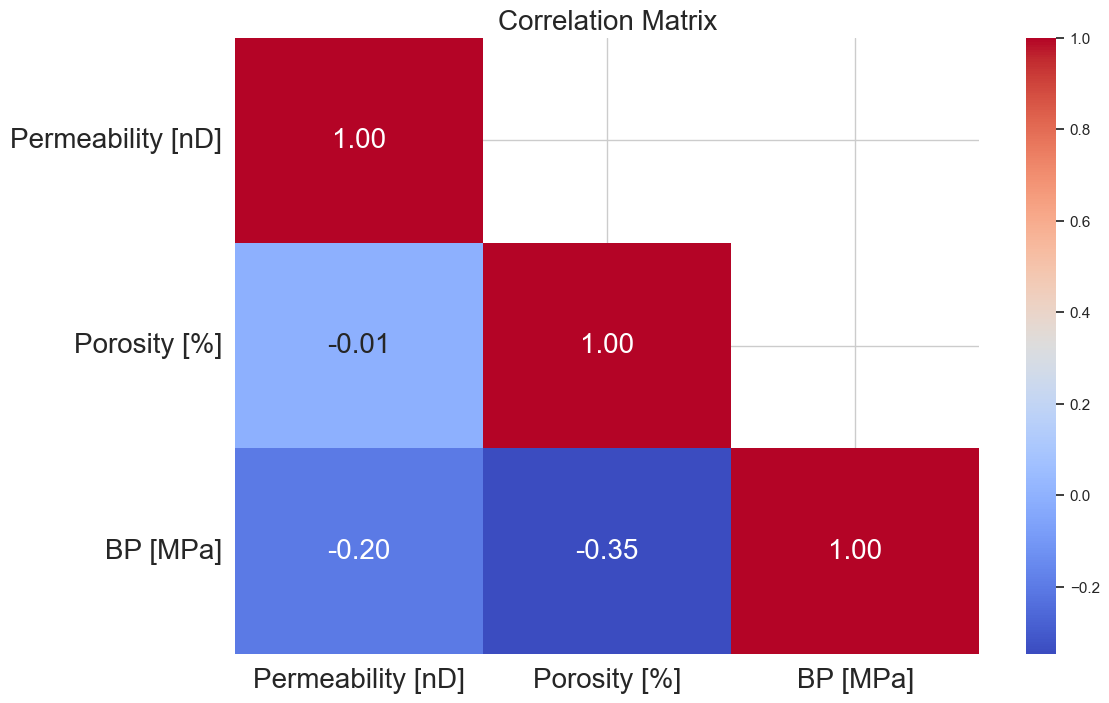

In [179]:
df.rename(columns={'Breakthrough pressure [MPa]': 'BP [MPa]'}, inplace=True)

cols = ['Permeability [nD]', 'Porosity [%]',  'BP [MPa]']
correlation_matrix = df[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(fontsize=20, fontname='Arial')
plt.show()

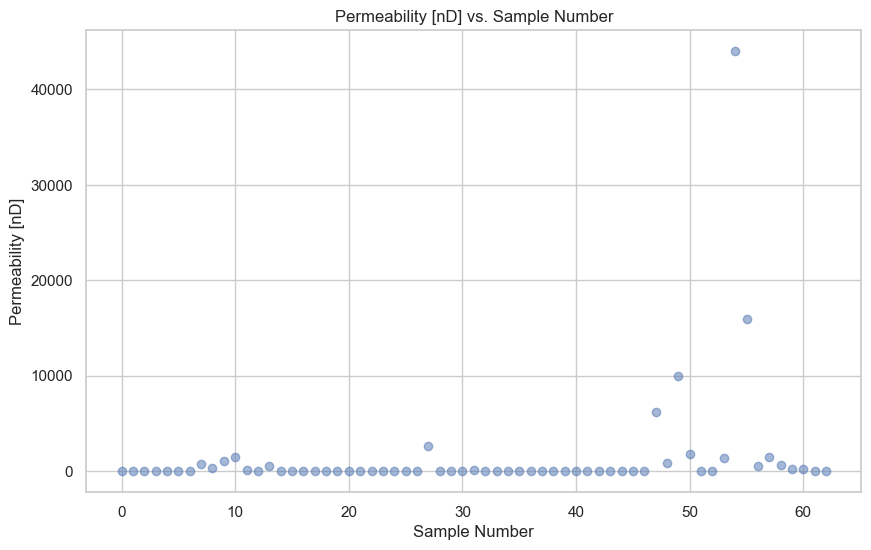

In [180]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Permeability [nD]'], alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Permeability [nD]')
plt.title('Permeability [nD] vs. Sample Number')
plt.show()

## Data Preprocessing

In [181]:
df.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'BP [MPa]'],
      dtype='object')

In [182]:
feature_columns = ['P’[MPa]','Permeability [nD]', 'Porosity [%]']
target_column= 'BP [MPa]'

In [183]:
# Encoding
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

df.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'BP [MPa]'],
      dtype='object')

In [184]:
# Replace special symbols in column names
df = df.rename(columns={"P’[MPa]": "P1", "Permeability [nD]": "P2", 
                        'Porosity [%]': 'P3', 'BP [MPa]':'Target'})
df.columns = df.columns.str.replace('[^A-Za-z0-9]+', '_')
print(df.columns)

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'Target'], dtype='object')


In [185]:
feature_columns = ['P1', 'P2', 'P3']
target_column= 'Target'

In [186]:
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
X_train.shape

(50, 3)

In [188]:
X_test.shape

(13, 3)

## Model Building


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 9.507762424158155
Mean Absolute Error (MAE): 2.054512728544382
R-squared (R2): 0.2397785316882327


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_72807/1919750084.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


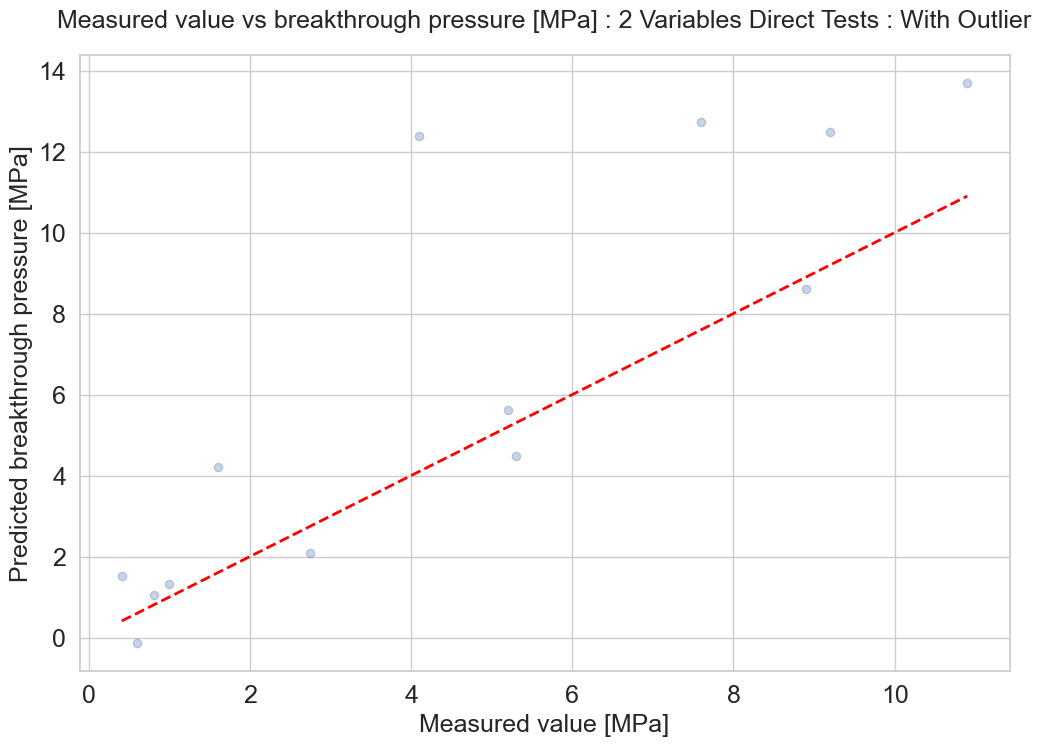

In [189]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=18, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=18, fontname='Arial')
plt.title('Measured value vs breakthrough pressure [MPa] : 2 Variables Direct Tests : With Outlier', fontsize=18, fontname='Arial', pad=20)
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()

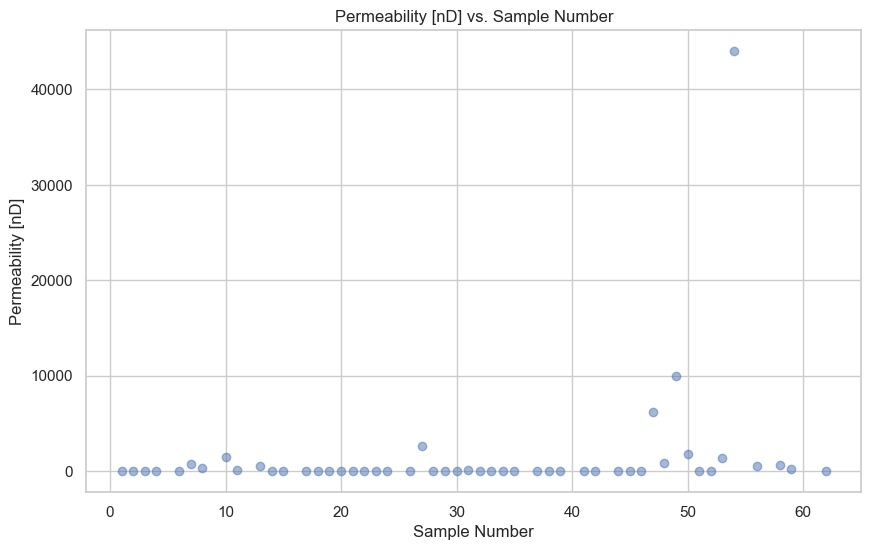

In [190]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train.index, X_train['P2'], alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Permeability [nD]')
plt.title('Permeability [nD] vs. Sample Number')
plt.show()

In [191]:
df[df['P2']>10000]

,Reference,Rock,P1,P2,P3,Target
54,3,3,NaN,44000.0,17.0,0.31
55,3,3,NaN,16000.0,14.5,0.60


In [192]:
df = df[df['P2']<10000]

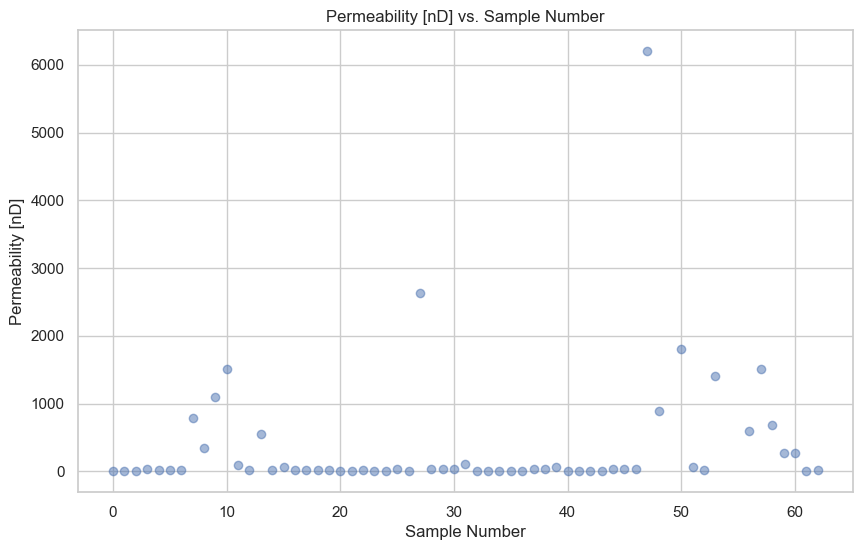

In [193]:
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['P2'], alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Permeability [nD]')
plt.title('Permeability [nD] vs. Sample Number')
plt.show()

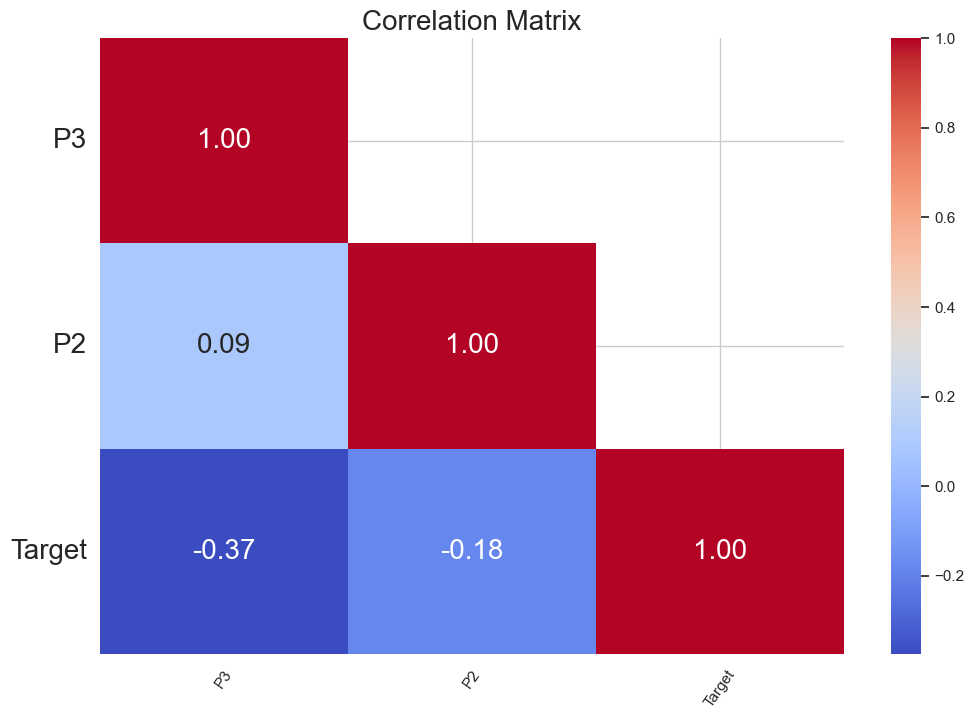

In [194]:
#df.rename(columns={'Breakthrough pressure [MPa]': 'BP [MPa]'}, inplace=True)

cols = ['P3', 'P2',  'Target']
correlation_matrix = df[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(rotation=55, fontname='Arial')
plt.show()

In [195]:
df.shape

(60, 6)

In [196]:
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
X_train.shape

(48, 3)

In [198]:
X_test.shape

(12, 3)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mean Squared Error (MSE): 39.03045370854596
Mean Absolute Error (MAE): 3.6076805496215822
R-squared (R2): 0.27606806945645257


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_72807/465106160.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


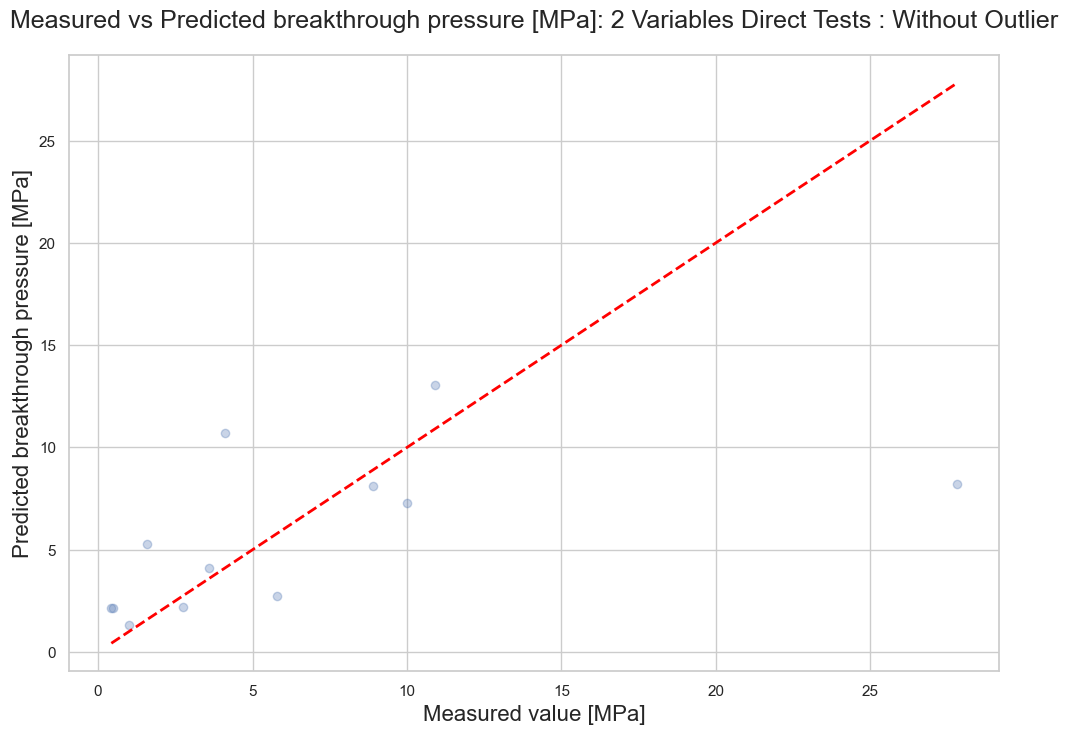

In [199]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=16)
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=16)
plt.title('Measured vs Predicted breakthrough pressure [MPa]: 2 Variables Direct Tests : Without Outlier', fontsize=18, pad=20)
plt.show()


# Prediction of Breakthrough Pressure with 5 Variables: Direct Tests

## Exploratory Data Analysis

In [200]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]'],
      dtype='object')

In [201]:
# Display the summary statistics
print("\nSummary statistics:")
df1.describe()


Summary statistics:


,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
count,36.000000,36.000000,36.000000,34.000000,36.000000,36.000000,36.000000
mean,14.325000,215.816667,19.383333,35.142059,38.083333,47.488889,4.438056
std,6.905872,530.239750,12.378357,73.319969,34.120898,28.823807,4.120411
min,5.000000,2.000000,5.000000,0.600000,4.000000,0.000000,0.400000
25%,8.875000,9.250000,12.000000,11.000000,20.000000,31.000000,0.840000
50%,15.000000,29.650000,15.000000,14.900000,30.000000,48.600000,3.800000
75%,20.000000,61.200000,24.000000,21.100000,56.250000,56.000000,5.850000
max,25.000000,2634.000000,54.500000,320.000000,170.000000,100.000000,17.500000


In [202]:
# Check for missing values
print("\nMissing values in each column:")
print(df1.isnull().sum())


Missing values in each column:
Reference                      0
Rock                           0
P’[MPa]                        0
Permeability [nD]              0
Porosity [%]                   0
SSA [m2g-1]                    2
Pore diameter [nm]             0
Clay content [%]               0
Breakthrough pressure [MPa]    0
dtype: int64


In [203]:
# Check the data types of each column
print("\nData types of each column:")
print(df1.dtypes)


Data types of each column:
Reference                       object
Rock                            object
P’[MPa]                        float64
Permeability [nD]              float64
Porosity [%]                   float64
SSA [m2g-1]                    float64
Pore diameter [nm]             float64
Clay content [%]               float64
Breakthrough pressure [MPa]    float64
dtype: object


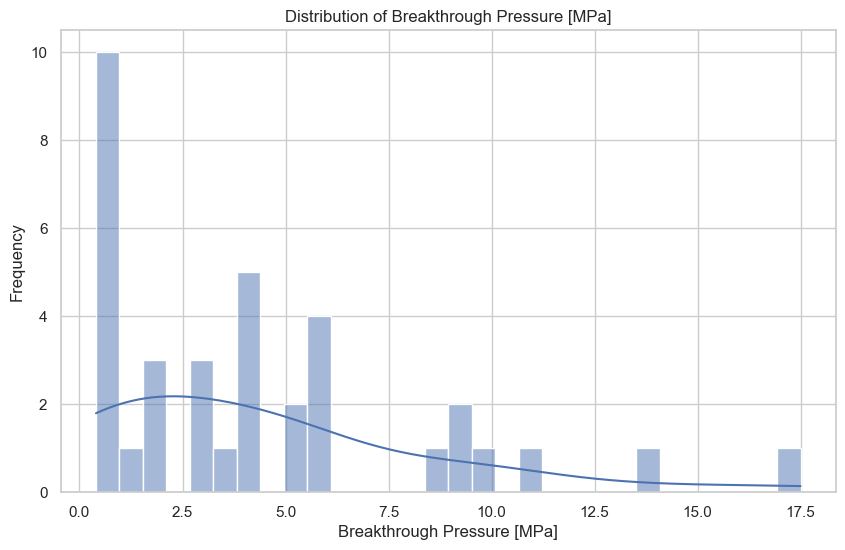

In [204]:
# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df1['Breakthrough pressure [MPa]'], bins=30, kde=True)
plt.title('Distribution of Breakthrough Pressure [MPa]')
plt.xlabel('Breakthrough Pressure [MPa]')
plt.ylabel('Frequency')
plt.show()

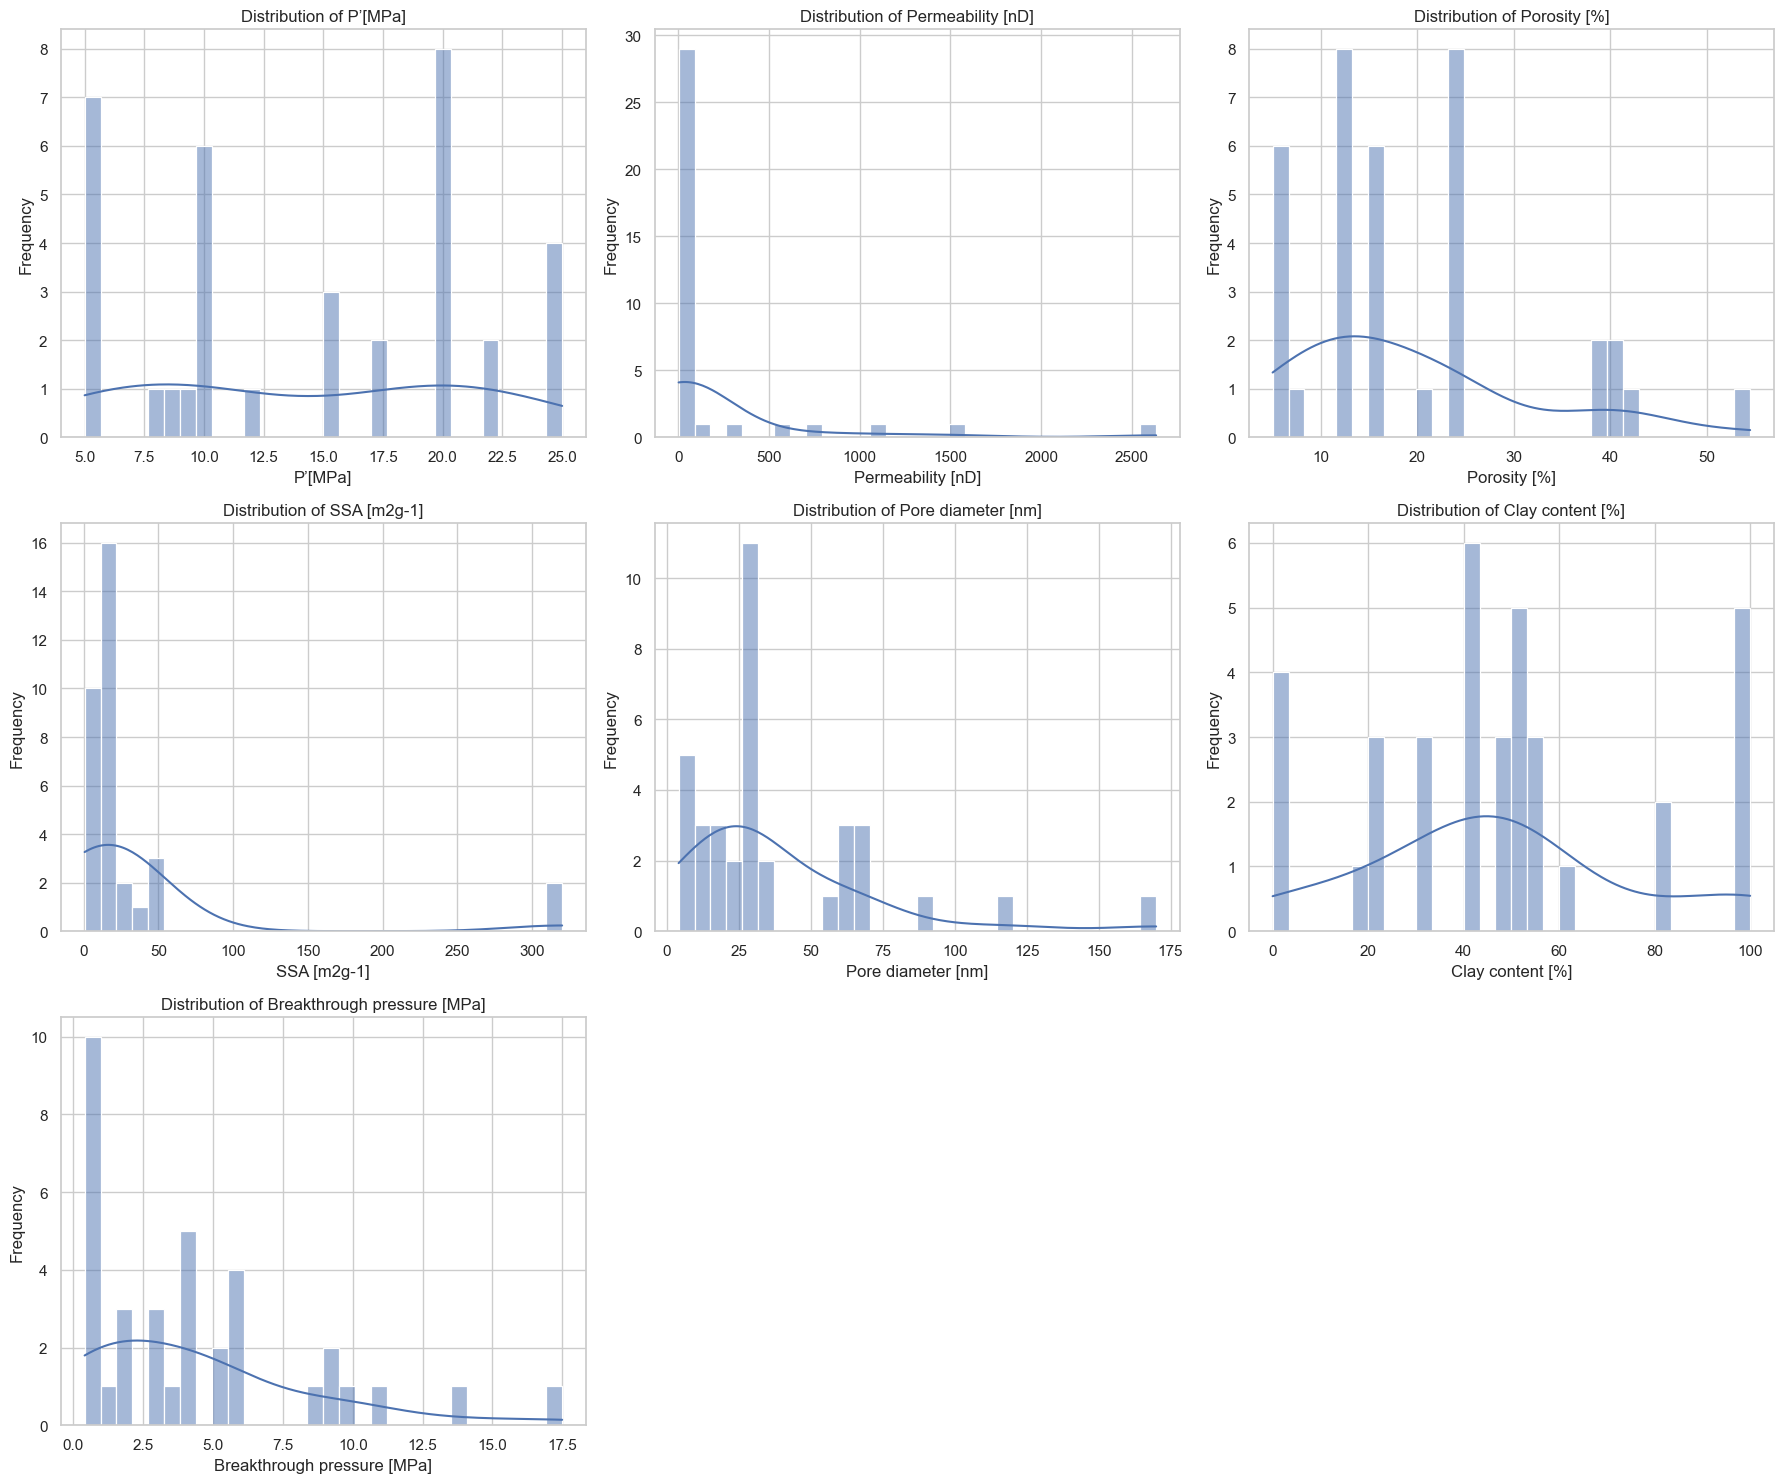

In [205]:
feature_columns = ['P’[MPa]',
       'Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]',
       'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]']

num_features = len(feature_columns)
num_rows = (num_features + 2) // 3  
fig, axes = plt.subplots(num_rows, 3, figsize=(18, 5 * num_rows))
axes = axes.flatten()

for i, column in enumerate(feature_columns):
    sns.histplot(df1[column], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [206]:
df1.head()

,Reference,Rock,P’[MPa],Permeability [nD],Porosity [%],SSA [m2g-1],Pore diameter [nm],Clay content [%],Breakthrough pressure [MPa]
0,Amann-Hildenbrand 2013,Opalinus Clay,25.0,6.9,11.6,39.0,14.0,60.0,4.1
1,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.0,13.0,NaN,10.0,80.0,17.5
2,Amann-Hildenbrand et al. 2015,Opalinus Clay,25.0,2.5,13.0,NaN,10.0,80.0,14.0
3,Hildenbrand et al. 2004,Boom Clay,20.0,557.0,24.4,20.1,170.0,3.0,5.8
4,Hildenbrand et al. 2004,Boom Clay,20.0,24.3,23.5,23.6,55.0,40.0,6.0


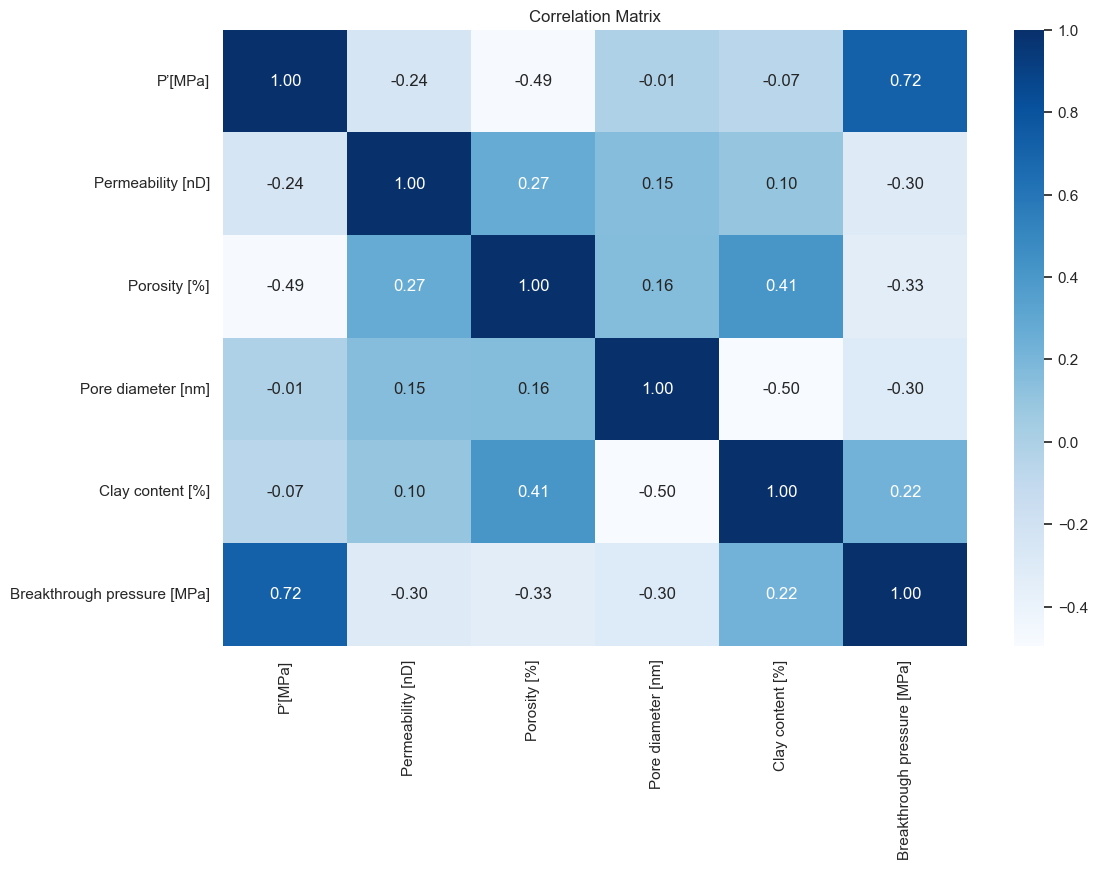

In [207]:
# Visualize correlations between features and the target variable
cols = ['P’[MPa]',
       'Permeability [nD]', 'Porosity [%]',
       'Pore diameter [nm]', 'Clay content [%]',
       'Breakthrough pressure [MPa]']
correlation_matrix = df1[cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

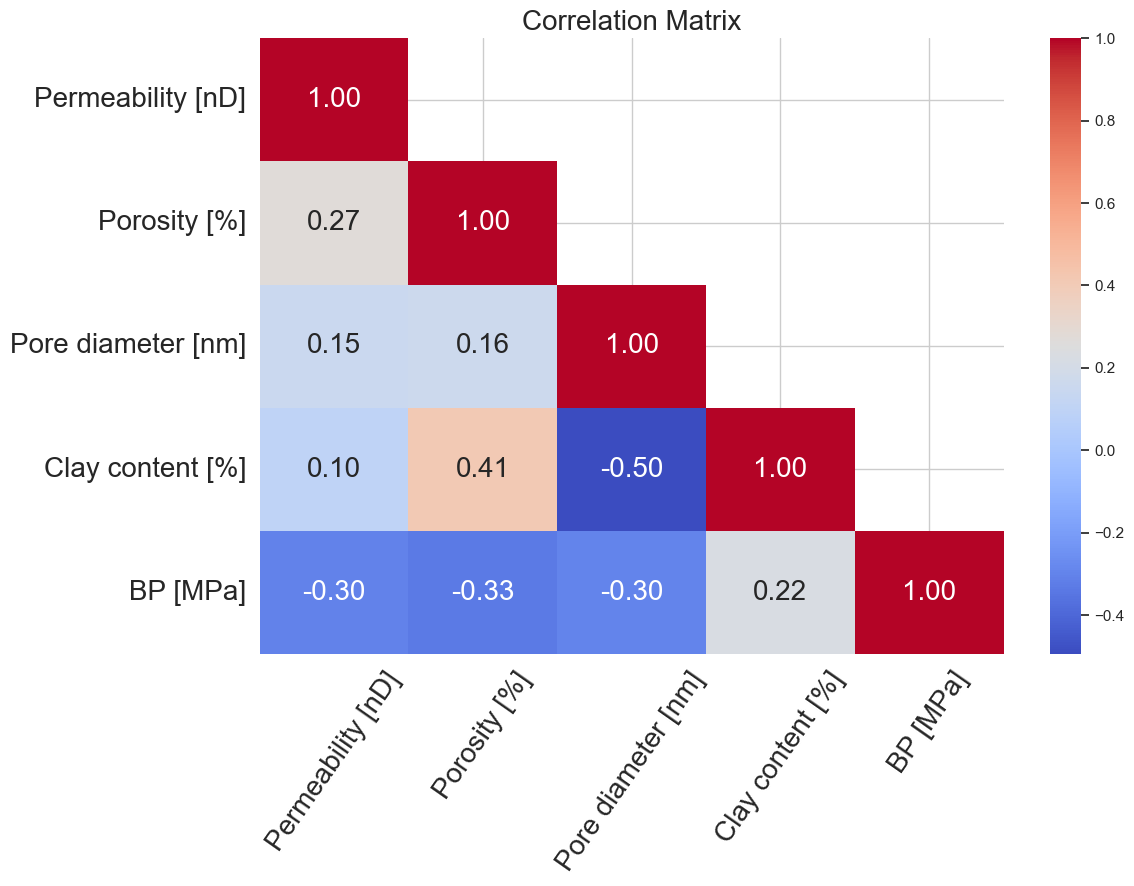

In [208]:
df1.rename(columns={'Breakthrough pressure [MPa]': 'BP [MPa]'}, inplace=True)

cols = ['Permeability [nD]', 'Porosity [%]', 
       'Pore diameter [nm]', 'Clay content [%]',
       'BP [MPa]']
correlation_matrix = df1[cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=mask, cmap='coolwarm', 
            fmt='.2f', annot_kws={"size": 20})
plt.title('Correlation Matrix', fontsize=20, fontname='Arial')
plt.yticks(rotation=0, fontsize=20, fontname='Arial')
plt.xticks(rotation=55, fontsize=20, fontname='Arial')
plt.show()

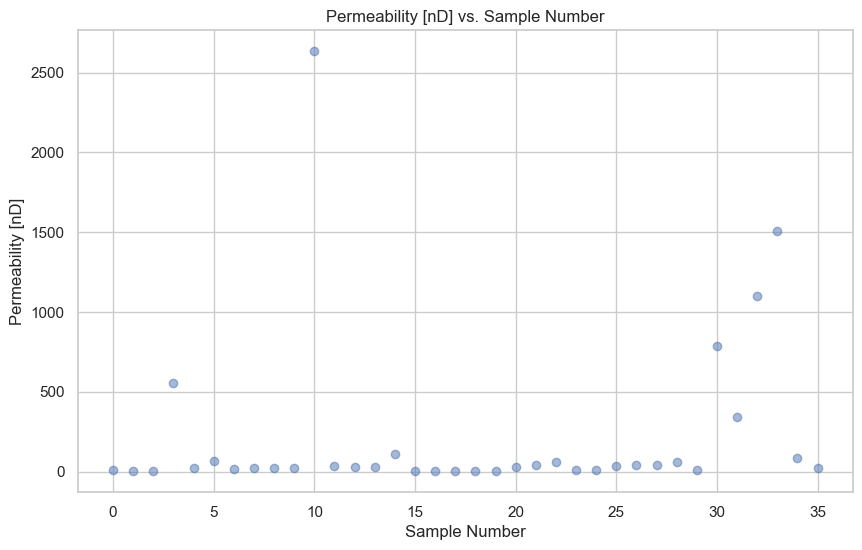

In [209]:
plt.figure(figsize=(10, 6))
plt.scatter(df1.index, df1['Permeability [nD]'], alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Permeability [nD]')
plt.title('Permeability [nD] vs. Sample Number')
plt.show()

## Data Preprocessing

In [210]:
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]', 'BP [MPa]'],
      dtype='object')

In [211]:
feature_columns = [
       'Permeability [nD]', 'Porosity [%]', 'SSA [m2g-1]',
       'Pore diameter [nm]', 'Clay content [%]']
target_column= 'BP [MPa]'

In [212]:
# Encoding
label_encoders = {}
for column in df1.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df1[column] = label_encoders[column].fit_transform(df1[column])
df1.columns

Index(['Reference', 'Rock', 'P’[MPa]', 'Permeability [nD]', 'Porosity [%]',
       'SSA [m2g-1]', 'Pore diameter [nm]', 'Clay content [%]', 'BP [MPa]'],
      dtype='object')

In [213]:
# Replace special symbols in column names
df1 = df1.rename(columns={"P’[MPa]": "P1", "Permeability [nD]": "P2", 
                        'Porosity [%]': 'P3','Pore diameter [nm]': 'P4',
                          'Clay content [%]': 'P5', 'SSA [m2g-1]': 'P6','BP [MPa]':'Target'})
df1.columns = df1.columns.str.replace('[^A-Za-z0-9]+', '_')
print(df1.columns)

Index(['Reference', 'Rock', 'P1', 'P2', 'P3', 'P6', 'P4', 'P5', 'Target'], dtype='object')


In [214]:
feature_columns = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6']
target_column= 'Target'
X = df1[feature_columns]
y = df1[target_column]

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(28, 6)

In [216]:
X_test.shape

(8, 6)

## Model Building

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Mean Squared Error (MSE): 1.4037250694476213
Mean Absolute Error (MAE): 1.0191778671741485
R-squared (R2): 0.8317390567206255


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_72807/756005667.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


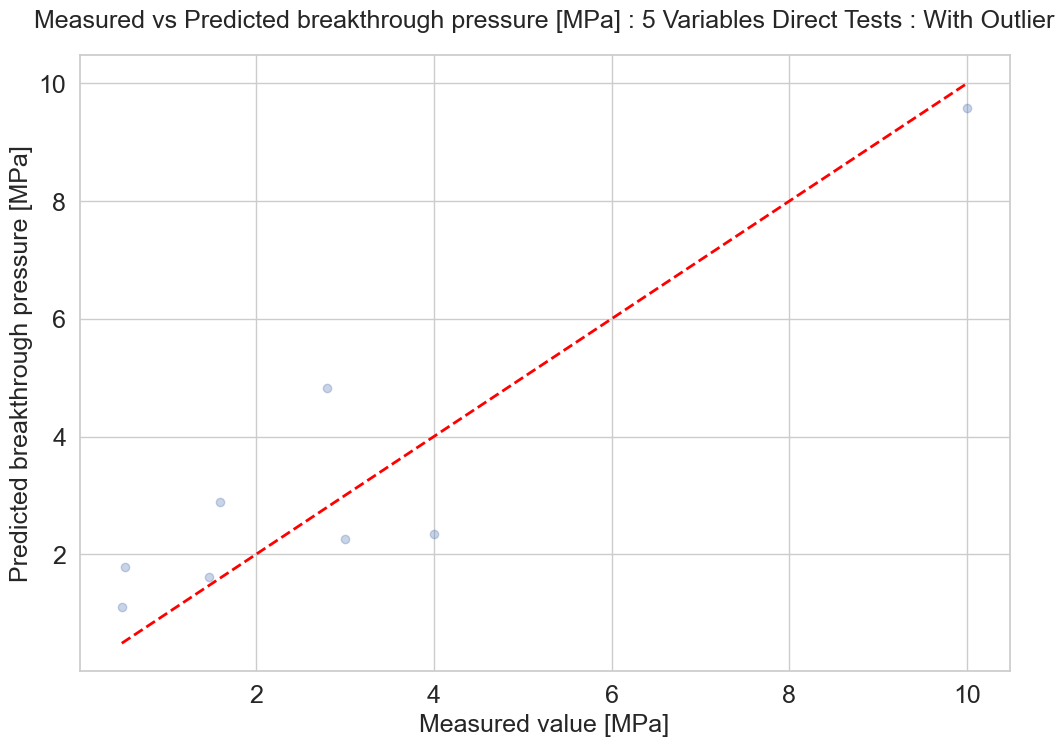

In [217]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=18, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=18, fontname='Arial')
plt.title('Measured vs Predicted breakthrough pressure [MPa] : 5 Variables Direct Tests : With Outlier', fontsize=18, fontname='Arial', pad=20)
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()

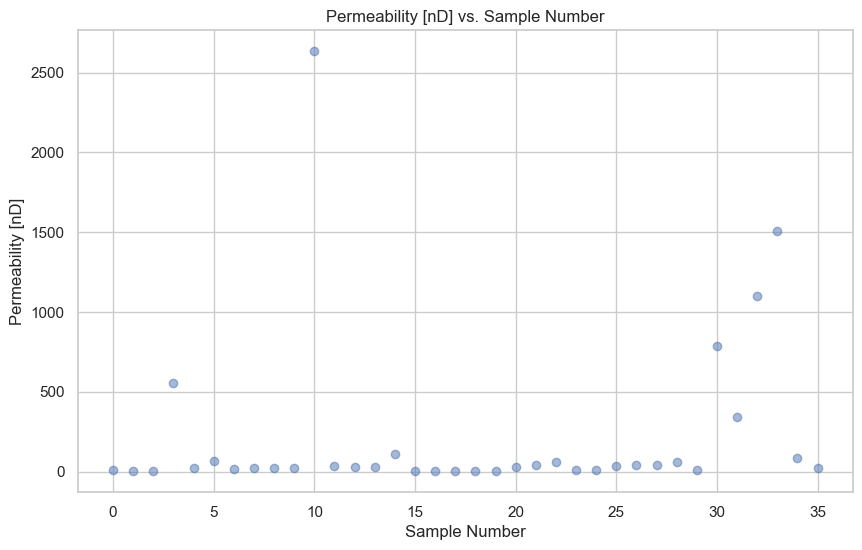

In [218]:
plt.figure(figsize=(10, 6))

plt.scatter(df1.index, df1['P2'], alpha=0.5)
plt.xlabel('Sample Number')
plt.ylabel('Permeability [nD]')
plt.title('Permeability [nD] vs. Sample Number')
plt.show()

In [219]:
df1 = df1[df1['P2']<10000]

In [220]:
feature_columns = ['P1', 'P2', 'P3', 'P4', 'P5']
target_column= 'Target'

In [221]:
X = df1[feature_columns]
y = df1[target_column]

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(28, 5)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Mean Squared Error (MSE): 1.212273744496226
Mean Absolute Error (MAE): 0.9074617311358452
R-squared (R2): 0.8546878386648593


/var/folders/xp/jy5j7tmd2c7bsktzm4pdpxm40000gn/T/ipykernel_72807/271586696.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')


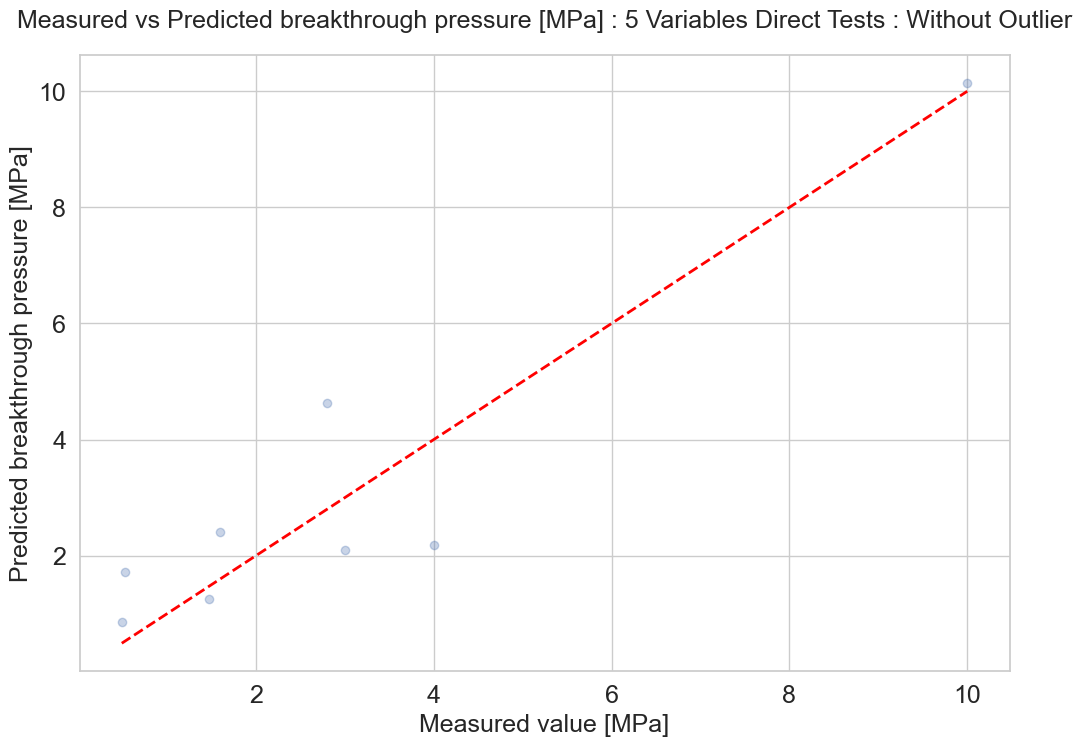

In [223]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBRegressor model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, color='red')
plt.xlabel('Measured value [MPa]', fontsize=18, fontname='Arial')
plt.ylabel('Predicted breakthrough pressure [MPa]', fontsize=18, fontname='Arial')
plt.title('Measured vs Predicted breakthrough pressure [MPa] : 5 Variables Direct Tests : Without Outlier', fontsize=18, fontname='Arial', pad=20)
plt.xticks(fontsize=18, fontname='Arial')
plt.yticks(fontsize=18, fontname='Arial')
plt.show()